# Running the model

Running your model requires translating the RCMIP inputs into your model's native input, running the model, and then saving the output. This step will look quite different depending on the RCM which is being run. The cells below provide an example of how this looks with the `openscm-twolayermodel` package.

In [1]:
import os
import os.path

import matplotlib.pyplot as plt
import numpy as np
import openscm_units.unit_registry as ur
import tqdm.autonotebook as tqdman
from openscm_twolayermodel import TwoLayerModel
from scmdata import ScmRun, run_append

/Users/znicholls/Documents/AGCEC/RCMIP/pyrcmip/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


## Loading inputs

The first thing to do is load the inputs from disk. Here we load the inputs using [`scmdata`](github.com/openscm/scmdata). For other groups, this step will likely be quite different.

The two-layer model is an effective radiative forcing driven model, hence we only need to load RCMIP's effective radiative forcings to run it. Models which are concentration-driven or emissions-driven will have to load RCMIP's concentration and/or emissions inputs to run.

In [2]:
DATA_PATH = os.path.join(
    "data",
    "rcmip-protocols",
    "rcmip-radiative-forcing-annual-means-v4-0-0.csv",
)
DATA_PATH

'data/rcmip-protocols/rcmip-radiative-forcing-annual-means-v4-0-0.csv'

In [3]:
ssps = ScmRun(DATA_PATH, lowercase_cols=True).filter(
    variable="Effective Radiative Forcing"
)
ssps

<scmdata.ScmRun (timeseries: 11, timepoints: 751)>
Time:
	Start: 1750-01-01T00:00:00
	End: 2500-01-01T00:00:00
Meta:
	               model                   scenario region  \
	58           AIM/CGE                     ssp370  World   
	77           AIM/CGE  ssp370-lowNTCF-aerchemmip  World   
	96           AIM/CGE      ssp370-lowNTCF-gidden  World   
	115            GCAM4                     ssp434  World   
	134            GCAM4                     ssp460  World   
	211            IMAGE                     ssp119  World   
	230            IMAGE                     ssp126  World   
	307  MESSAGE-GLOBIOM                     ssp245  World   
	384    REMIND-MAGPIE                ssp534-over  World   
	403    REMIND-MAGPIE                     ssp585  World   
	422      unspecified                 historical  World   
	
	                        variable   unit mip_era     activity_id  
	58   Effective Radiative Forcing  W/m^2   CMIP6  not_applicable  
	77   Effective Radiative Forcing  W/m^

<AxesSubplot:xlabel='time', ylabel='W/m^2'>

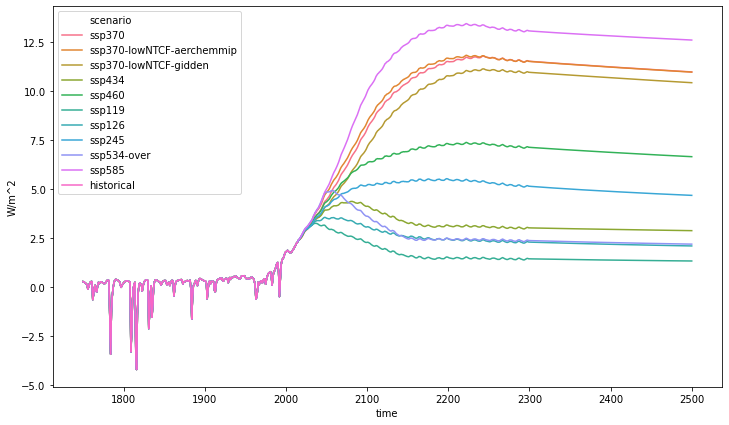

In [4]:
# we can also make a quick plot
ssps.lineplot(ax=plt.figure(figsize=(12, 7)).add_subplot(111))

## Converting inputs to the model's native format

Next the data must be converted to the model's native format. Depending on the model, this step could be quite tricky. In our case, we want to add the idealised CO$_2$ only experiments (1pctCO2, abrupt-4xCO2, abrupt-2xCO2, abrupt-0p5xCO2). We can do this, but only by first adding two extra inputs:

1. the assumption that CO$_2$ effective radiative forcing scales logarithmically with CO$_2$ concentrations
1. the radiative forcing due to a doubling of atmospheric CO$_2$ concentrations.

Here we assume that the effective radiative forcing due to a doubling of atmospheric CO$_2$ concentrations is 4.0 W m$^{-2}$. 

In [5]:
f2x_co2 = 4.0 * ur("W/m^2")
f2x_co2

4.0 <Unit('watt / meter ** 2')>

Now we can add the idealised scenarios.

In [6]:
erf_unit = "W/m^2"
idealised_scenarios_common_metadata = {
    "model": "idealised",
    "variable": "Effective Radiative Forcing",
    "unit": erf_unit,
    "region": "World",
    "activity_id": "not_applicable",
    "mip_era": "CMIP6",
}

In [7]:
one_pctCO2_years = np.arange(1850, 2200)
one_pctCO2_years

array([1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860,
       1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871,
       1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882,
       1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893,
       1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904,
       1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915,
       1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926,
       1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937,
       1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948,
       1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,
       1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 20

time                                                                                1920-01-01 00:00:00
scenario model     variable                    unit  region activity_id    mip_era                     
1pctCO2  idealised Effective Radiative Forcing W/m^2 World  not_applicable CMIP6                    4.0

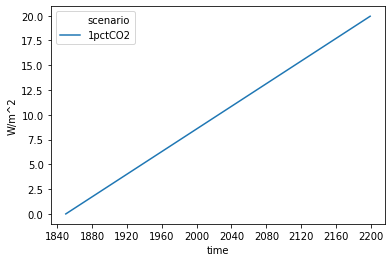

In [8]:
one_pctCO2 = ScmRun(
    # atmospheric CO2 quadruples after 140 years, so forcing doubles
    # after 70 years
    ((one_pctCO2_years - one_pctCO2_years[0]) * f2x_co2 / 70).to(erf_unit).magnitude,
    index=one_pctCO2_years, 
    columns={
        "scenario": "1pctCO2",
        **idealised_scenarios_common_metadata
    }
)
one_pctCO2.lineplot()
one_pctCO2.filter(year=1920).head()

In [9]:
idealised_run_years = np.arange(1850, 5000)
idealised_run_years

array([1850, 1851, 1852, ..., 4997, 4998, 4999])

<AxesSubplot:xlabel='time', ylabel='W/m^2'>

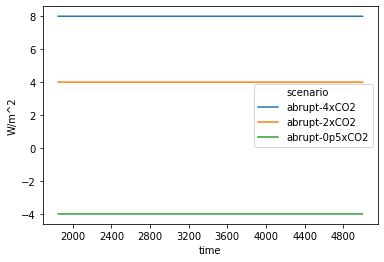

In [10]:
idealised_runs = []
for facor, name in ((4, "4"), (2, "2"), (-2, "0p5")):
    idealised = ScmRun(
        (f2x_co2 * facor / 2 * np.ones_like(idealised_run_years)).to(erf_unit).magnitude,
        index=idealised_run_years, 
        columns={
            "scenario": "abrupt-{}xCO2".format(name),
            **idealised_scenarios_common_metadata
        }
    )
    idealised_runs.append(idealised)
    
idealised_runs = run_append(idealised_runs)
idealised_runs.lineplot()

<AxesSubplot:xlabel='time', ylabel='W/m^2'>

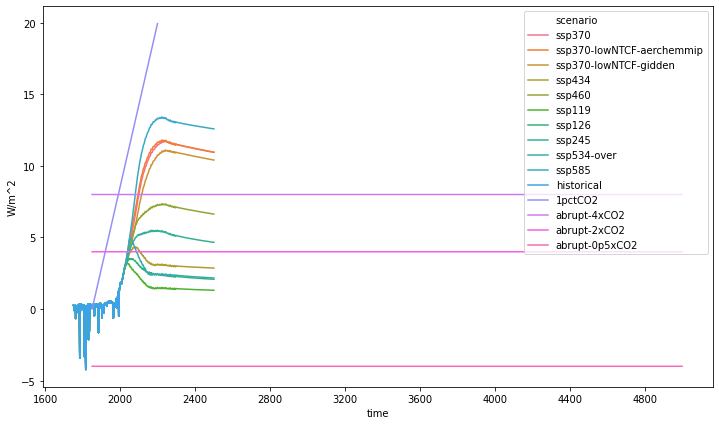

In [11]:
full_scenarios = run_append([ssps, one_pctCO2, idealised_runs])
full_scenarios.lineplot(ax=plt.figure(figsize=(12, 7)).add_subplot(111))

## Setting model configuration

Next the model's configuration must be decided. Again, depending on the model, this could be very tricky. In this example, we simply run the model for the equilibrium climate sensitivity (ECS) values of: 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5 and 7K. This is not an intelligently derived probabilistic distribution, but it will give us enough runs for an example.

In [12]:
ecss = np.arange(1.5, 7.1, 0.5) * ur("delta_degC")
ecss

array([1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. ]) <Unit('delta_degree_Celsius')>

From these two settings, we can determine the appropriate feedback factor, $\lambda$, for each ECS.

In [13]:
lambda0s = f2x_co2 / ecss
lambda0s

array([2.66666667, 2.        , 1.6       , 1.33333333, 1.14285714,
       1.        , 0.88888889, 0.8       , 0.72727273, 0.66666667,
       0.61538462, 0.57142857]) <Unit('watt / delta_degree_Celsius / meter ** 2')>

In [14]:
cfgs = [
    (i, ecs, {"lambda0": lambda0})
    for i, (ecs, lambda0) in enumerate(zip(ecss, lambda0s))
]
cfgs[:2]

[(0,
  1.5 <Unit('delta_degree_Celsius')>,
  {'lambda0': 2.6666666666666665 <Unit('watt / delta_degree_Celsius / meter ** 2')>}),
 (1,
  2.0 <Unit('delta_degree_Celsius')>,
  {'lambda0': 2.0 <Unit('watt / delta_degree_Celsius / meter ** 2')>})]

## Run the model

We also save the ECS for each ensemble member as we will want to know it later.

In [15]:
res = []
for ensemble_member, ecs, cfg in tqdman.tqdm(cfgs, desc="Parameter settings"):
    runner = TwoLayerModel(**cfg)
    res_run = runner.run_scenarios(full_scenarios)
    res_run["ensemble_member"] = ensemble_member
    res_run["ecs (K)"] = ecs.to("delta_degC").magnitude
    res.append(res_run)

res = run_append(res)
res.head()

time                                                                                                                                                                                                                                                                                                                                                     1750-01-01 00:00:00  \
model   scenario                  region variable                    unit       climate_model run_idx lambda0 (watt / delta_degree_Celsius / meter ** 2) eta (watt / delta_degree_Celsius / meter ** 2) a (watt / delta_degree_Celsius ** 2 / meter ** 2) efficacy (dimensionless) dl (meter) mip_era du (meter) activity_id    ensemble_member ecs (K)                        
AIM/CGE ssp370                    World  Effective Radiative Forcing W/m^2      two_layer     0       2.666667                                           0.8                                            0.0                                               1.0                      1200       CMIP6   50         not_applicable 0               1.5                 0.259367   
                                         Surface Temperature|Upper   delta_degC two_layer     0       2.666667                                           0.8                                            0.0                                               1.0                      1200       CMIP6   50         not_applicable 0               1.5                 0.000000   
                                         Surface Temperature|Lower   delta_degC two_layer     0       2.666667                                           0.8                                            0.0                                               1.0                      1200       CMIP6   50         not_applicable 0               1.5                 0.000000   
                                         Heat Uptake                 W/m^2      two_layer     0       2.666667                                           0.8                                            0.0                                               1.0                      1200       CMIP6   50         not_applicable 0               1.5                 0.000000   
        ssp370-lowNTCF-aerchemmip World  Effective Radiative Forcing W/m^2      two_layer     1       2.666667                                           0.8                                            0.0                                               1.0                      1200       CMIP6   50         not_applicable 0               1.5                 0.259367   

time                                                                                                                                                                                                                                                                                                                                                     1751-01-01 00:00:00  \
model   scenario                  region variable                    unit       climate_model run_idx lambda0 (watt / delta_degree_Celsius / meter ** 2) eta (watt / delta_degree_Celsius / meter ** 2) a (watt / delta_degree_Celsius ** 2 / meter ** 2) efficacy (dimensionless) dl (meter) mip_era du (meter) activity_id    ensemble_member ecs (K)                        
AIM/CGE ssp370                    World  Effective Radiative Forcing W/m^2      two_layer     0       2.666667                                           0.8                                            0.0                                               1.0                      1200       CMIP6   50         not_applicable 0               1.5                 0.242788   
                                         Surface Temperature|Upper   delta_degC two_layer     0       2.666667                                           0.8                                            0.0                                               1.0                      1200       CMIP6   50         not_applicable

For the purposes of this example, we'll also add a `Surface Air Ocean Blended Temperature Change` output which is simply the `Surface Temperature|Upper` divided by 1.05.

In [16]:
temp_blended = res.filter(variable="Surface Temperature|Upper") / 1.05
temp_blended["variable"] = "Surface Air Ocean Blended Temperature Change"
temp_blended

<scmdata.ScmRun (timeseries: 180, timepoints: 3250)>
Time:
	Start: 1750-01-01T00:00:00
	End: 4999-01-01T00:00:00
Meta:
	            model                   scenario region  \
	594       AIM/CGE                     ssp370  World   
	598       AIM/CGE  ssp370-lowNTCF-aerchemmip  World   
	602       AIM/CGE      ssp370-lowNTCF-gidden  World   
	606         GCAM4                     ssp434  World   
	610         GCAM4                     ssp460  World   
	...           ...                        ...    ...   
	2284  unspecified                 historical  World   
	2288    idealised                    1pctCO2  World   
	2292    idealised               abrupt-4xCO2  World   
	2296    idealised               abrupt-2xCO2  World   
	2300    idealised             abrupt-0p5xCO2  World   
	
	                                          variable        unit climate_model  \
	594   Surface Air Ocean Blended Temperature Change  delta_degC     two_layer   
	598   Surface Air Ocean Blended Temperature 

In [17]:
res = res.append(temp_blended)

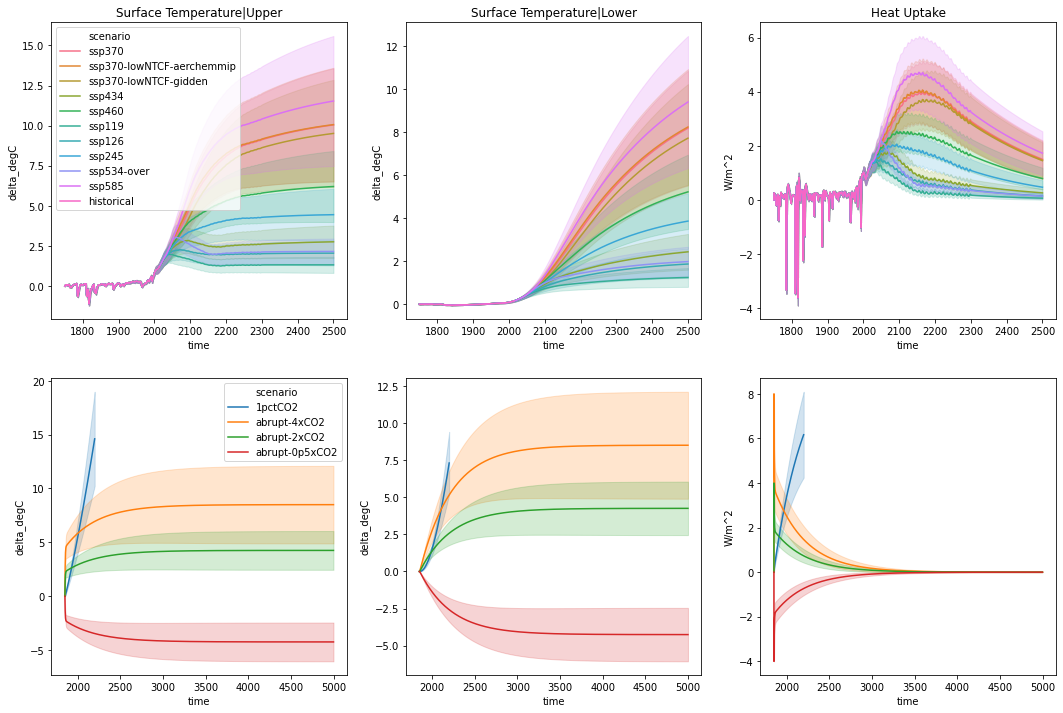

In [18]:
# this cell is a bit slow
scenario_filters = [
    ["ssp*", "historical"], 
    ["abrupt*", "1pctCO2"]
]

variables = [
    "Surface Temperature|Upper", 
    "Surface Temperature|Lower", 
    "Heat Uptake"
]

fig, axes = plt.subplots(
    nrows=len(scenario_filters), 
    ncols=len(variables), 
    figsize=(len(variables) * 6, len(scenario_filters) * 6)
)

for i, scenario_filter in tqdman.tqdm(enumerate(scenario_filters), desc="Scenarios"):
    for j, variable in tqdman.tqdm(enumerate(variables), desc="Variables", leave=False):
        ax = axes[i][j]
        res.filter(variable=variable, scenario=scenario_filter).lineplot(
            time_axis="year", 
            ax=ax,
            legend="brief" if j == 0 else None,
            ci="sd",
        )
        if i == 0:
            ax.set_title(variable)

<AxesSubplot:xlabel='time', ylabel='delta_degC'>

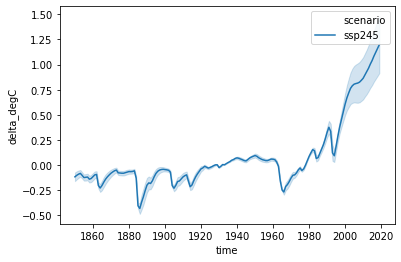

In [28]:
res.filter(
    variable="Surface Temperature|Upper", scenario="ssp245", year=range(1850, 2020)
).relative_to_ref_period_mean(year=range(1961, 1990 + 1)).lineplot()

## Save the output

The last thing to do at this stage is save the model output. At this stage, if possible, save the output into whatever format is convenient. The following notebooks show how the outputs can be transformed so that they're ready for submission.

If output can't be saved to disk, then all of the following notebooks have to be done in memory. The steps are the same in principle, the implementation is just slightly trickier because it has to be done 'all at once'.

Here we save the output using `scmdata` as it's convenient for us.

In [19]:
metadata_file = os.path.join("data", "output", "raw", "raw_metadata.csv")
metadata_file

'data/output/raw/raw_metadata.csv'

In [20]:
if not os.path.isdir(os.path.dirname(metadata_file)):
    os.makedirs(os.path.dirname(metadata_file))

In [21]:
res.meta.to_csv(metadata_file, index=False)
res.meta.head()

model scenario region                                      variable  \
593  AIM/CGE   ssp370  World                   Effective Radiative Forcing   
594  AIM/CGE   ssp370  World                     Surface Temperature|Upper   
594  AIM/CGE   ssp370  World  Surface Air Ocean Blended Temperature Change   
595  AIM/CGE   ssp370  World                     Surface Temperature|Lower   
596  AIM/CGE   ssp370  World                                   Heat Uptake   

           unit climate_model  run_idx  \
593       W/m^2     two_layer        0   
594  delta_degC     two_layer        0   
594  delta_degC     two_layer        0   
595  delta_degC     two_layer        0   
596       W/m^2     two_layer        0   

     lambda0 (watt / delta_degree_Celsius / meter ** 2)  \
593                                           2.666667    
594                                           2.666667    
594                                           2.666667    
595                                           2.666667    
596                                           2.666667    

     eta (watt / delta_degree_Celsius / meter ** 2)  \
593                                             0.8   
594                                             0.8   
594                                             0.8   
595                                             0.8   
596                                             0.8   

     a (watt / delta_degree_Celsius ** 2 / meter ** 2)  \
593                                                0.0   
594                                                0.0   
594                                                0.0   
595                                                0.0   
596                                                0.0   

     efficacy (dimensionless)  dl (meter) mip_era  du (meter)     activity_id  \
593                       1.0        1200   CMIP6          50  not_applicable   
594                       1.0        1200   CMIP6          50  not_applicable   
594                       1.0        1200   CMIP6          50  not_applicable   
595                       1.0        1200   CMIP6          50  not_applicable   
596                       1.0        1200   CMIP6          50  not_applicable   

     ensemble_member  ecs (K)  
593                0      1.5  
594                0      1.5  
594                0      1.5  
595                0      1.5  
596                0      1.5

In [22]:
output_file = os.path.join("data", "output", "raw", "raw_model_output.nc")
output_file

'data/output/raw/raw_model_output.nc'

In [23]:
meta_to_keep = {
    "climate_model",
    "ensemble_member",
    "variable",
    "unit", 
    "region",
    "model",
    "scenario", 
}
meta_to_drop = list(set(res.meta.columns) - meta_to_keep)
meta_to_drop

['du (meter)',
 'dl (meter)',
 'efficacy (dimensionless)',
 'run_idx',
 'activity_id',
 'lambda0 (watt / delta_degree_Celsius / meter ** 2)',
 'ecs (K)',
 'a (watt / delta_degree_Celsius ** 2 / meter ** 2)',
 'mip_era',
 'eta (watt / delta_degree_Celsius / meter ** 2)']

In [24]:
res = res.drop_meta(meta_to_drop, inplace=False)

In [25]:
res.to_nc(
    output_file, 
    dimensions=("scenario", "ensemble_member"),
    extras=("model",),
)